In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import os

import download_drive_data as ddd
import eval_data_formatter as edf

plt.style.use("bmh")

First we download the data from the google drive folder. The functions in ddd will ensure that the files are downloaded into a folder that will be ignored by git. It will also avoid overwriting data if it already exists locally.

In [2]:
try:
    ddd.download_folder("https://drive.google.com/drive/folders/1iJHOh6pBJC13yKVfcgykayG_F2aS1bvn?usp=drive_link")
except FileExistsError as e:
    print(e)

Retrieving folder contents


Processing file 1weWWmwcuUqliML3jq7qxmJ_UqncgNvcN 250221_1503_A0_S0.txt
Processing file 1wBlc8NdD7X4sRj_N-sbB5w-MqQDEL1O7 250221_1516_A1_S0.txt
Processing file 1UBRnYi16K69PUqK_Hwu4eulh5CSfPJST 250221_1520_A2_S0.txt
Processing file 1uwMOYSns0Ddlu6zJDNMSB8-ICiXfOB7T 250221_1527_A3_S0.txt
Processing file 1YMQ9RTWXrJ4FShkIArpoarkrKVRgu-_y 250221_1549_A0_S1.txt
Processing file 1tZHUEooeLOUWd1oCK59ncTu5qJkGPMGu 250221_1552_A1_S1.txt
Processing file 1WmmKJZ8TuBqeFvq7UNw8rJzHzLP_95ep 250221_1554_A2_S1.txt
Processing file 1ao6rPFzPAu54EW2InM6SSJqqn7Fj2Q1V 250221_1557_A3_S1.txt
Processing file 17qtrTdRU0GJRAdrKY5homg1lVR-rssrW 250221_1558_A0_R0.txt
Processing file 1uMxnu3EFIbs5KdnZejJXEikmibJQJl5h 250221_1559_A1_R0.txt
Processing file 1dev8xcrdJyNkUQaIIxTjbOy28nhYF4Ko 250221_1600_A2_R0.txt
Processing file 1VJY0jRMeAdCFEUJDciigGGU6dq_JLJpd 250221_1601_A3_R0.txt
Processing file 1CNOYJO9ij-iLmV6dMkpdR_77tYs6hqZG 250221_1604_A0_R1.txt
Processing file 19XJbQDiXek7JMBcBb-zFG4nanRo0WFWX 250221_1605_A1

Retrieving folder contents completed
Building directory structure
Building directory structure completed
Download completed


The raw eval software output is then parsed to extract the capacitance data and some header information. The EvalBoardData object hold this information along with some stuff like generating timestamps.

The capacitance data is stored as raw ADC counts in decimal. 

In [ ]:
data_directory = os.path.join(os.getcwd(), "data", "repeatability_data")
trial_data = edf.format_folder(data_directory)

In [4]:
cyclic_trials = []
reprod_trials = []
for trial in trial_data:
    if "S" in trial.trial_name:
        cyclic_trials.append(trial)
    if "R" in trial.trial_name:
        reprod_trials.append(trial)


In [26]:
def count2ff(counts):
    """24bit resolution measuring +/- 4.096 pF"""
    zero = 2**23
    return (counts - zero)*(4096/zero)


Two types of trials so far, cyclic loading and trials without any input.

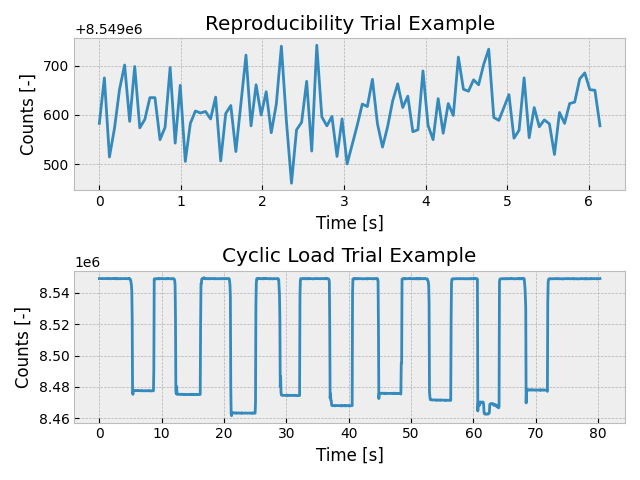

In [27]:
fix, axs = plt.subplots(2)

axs[0].plot(reprod_trials[0].time, reprod_trials[0].cap_counts)
axs[0].set_xlabel("Time [s]")
axs[0].set_ylabel("Counts [-]")
axs[0].set_title("Reproducibility Trial Example")

axs[1].plot(cyclic_trials[0].time, cyclic_trials[0].cap_counts)
axs[1].set_xlabel("Time [s]")
axs[1].set_ylabel("Counts [-]")
axs[1].set_title("Cyclic Load Trial Example")

plt.tight_layout()

Some trials will involve placing/removing the ground plane. In this case, it's convenient to just have data collection running and have the periods segmented during analysis (fewer files, less stopping and starting). In this case, we'll use the package ruptures which provides offline change point detection. 

https://github.com/deepcharles/ruptures

Changes Detected: 18
[  85  140  195  265  340  405  470  520  595  655  725  780  855  910
  980 1035 1105 1160 1296]


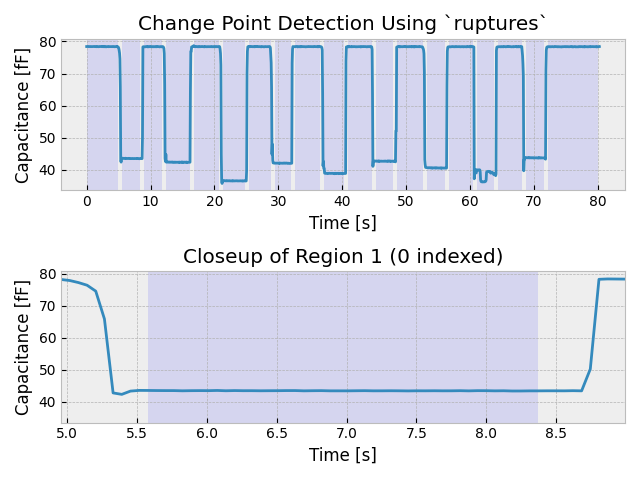

In [35]:
import ruptures as rpt

test_trial = cyclic_trials[0]

algo = rpt.Pelt(model="rbf").fit(test_trial.cap_counts)
change_points = np.array(algo.predict(pen=10))

# fig, axs = rpt.display(test_trial.cap_counts, [], change_points)
fig, axs = plt.subplots(2)
axs[0].plot(test_trial.time, count2ff(test_trial.cap_counts))
axs[0].set_title("Change Point Detection Using `ruptures`")
axs[0].set_xlabel("Time [s]")
axs[0].set_ylabel("Capacitance [fF]")

# This is -1 because it is really marking the end points of the stable regions 
# between changes. 
print(f"Changes Detected: {len(change_points)-1}")
print(change_points)

# Using a universal padding seems more stable than using a standard deviation 
# to define stable regions. Mainly because anomalies can happen in the stable
# regions. Although, this would be worth testing. 
change_padding = 5
region_starts = np.r_[0, change_points[:-1] + change_padding]
region_ends = change_points - change_padding

for start, end in zip(region_starts, region_ends):
    axs[0].axvspan(test_trial.time[start], test_trial.time[end], alpha=0.1)

axs[1].plot(test_trial.time, count2ff(test_trial.cap_counts))
axs[1].set_xlim(test_trial.time[region_ends[0]], test_trial.time[region_starts[2]])
axs[1].axvspan(test_trial.time[region_starts[1]], test_trial.time[region_ends[1]], alpha=0.1)
axs[1].set_title("Closeup of Region 1 (0 indexed)")
axs[1].set_xlabel("Time [s]")
axs[1].set_ylabel("Capacitance [fF]")
plt.tight_layout()

$C_{tr} + \Delta C_{tr}(x, y, z, g) + w$

Where 
- $C_{tr}$ is the mutual capacitance between a transmitter and receiver with the ground plane removed
- $\Delta C_{tr}(x, y, z, g)$ is the change in mutual capacitance induced by placing a ground plane of geometry $g$ at location $(x, y, z)$. Note, for these tests, $(x, y, z)$ are random variables.
- $w$ is random noise where we assume $w\sim \mathscr N (0, \sigma_w)$

Here's a model proposal. There is a baseline mutual capacitance $C_{tr}$ between transmitter $t$ and the receiver $r$ while the ground plane is at some neutral position. The measurement of this mutual capacitance is some $C_{tr} + w$ where $w \sim \mathscr N(0, \sigma_w)$ and is uncorrelated in time. When placing the ground plane into the scene, the amount of capacitance change is a function of the $(x, y, z)$ coordinate of the ground plane as well as its geometry, $g$. We'll call this change in capacitance $\Delta C_{tr}(x, y, z, g)$. The measured capacitance after placing the ground plane is then $C_{tr} + \Delta C_{tr}(x, y, z, g) + w$. 

Ideally in our tests, we repeat the same translations $(x, y, z)$, but there is error when we move the ground plane. Additionally, it's possible (and perhaps likely) that $w$ is a function of $(x, y, z, g)$ as well. 

Here's a list of things that may be good to test in no particular order
- estimate $\sigma_w$
- check if $w$ is a function of $(x, y, z, g)$
- compare $\Delta C_{tr}$ with different t's, r's, and electrode designs
- compare $\Delta C_{tr} / \sigma_w$ with different t's, r's, and electrode designs



The first step is to estimate the distribution of $w$ as this will contribute to error propogation when estimating $\Delta C_{tr}$. For each electrode, three trials were conducted by completely removing the receive probe and reattaching it. Data was collected for 100 samples without any interaction with the test setup. 

The electrodes are labeled A#. "A" for Arc (ie. the receive electrode), and the numbers go from 0 to 3 from the outside in. 

All plots have been scaled to have the same y-limits.

Median Standard Deviation for electrode 0: 0.0376fF
Median Standard Deviation for electrode 1: 0.0293fF
Median Standard Deviation for electrode 2: 0.0416fF
Median Standard Deviation for electrode 3: 0.0327fF


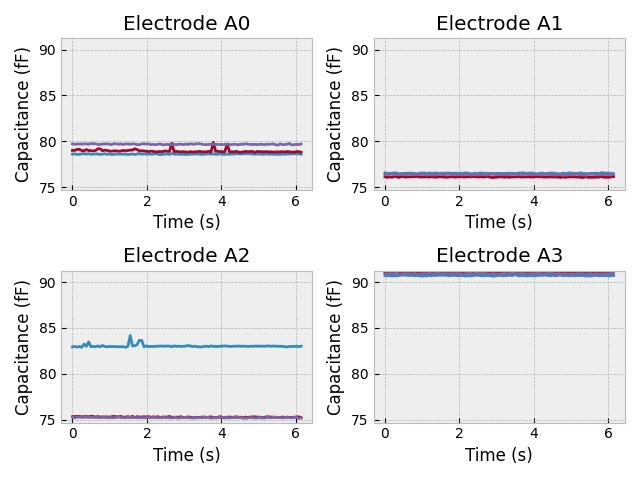

In [37]:
from collections import defaultdict
num_trials = 4
fig, axs = plt.subplots(2, 2)

smallest_y = np.inf
largest_y = -np.inf
std_devs = defaultdict(list)
for trial in reprod_trials:
    electrode = int(trial.trial_name.split("_")[2][1:])
    row = electrode // 2
    col = electrode % 2

    std_devs[electrode].append(np.std(count2ff(trial.cap_counts)))

    axs[row, col].plot(trial.time, count2ff(trial.cap_counts))
    ylims = axs[row, col].get_ylim()
    smallest_y = min(ylims[0], smallest_y)
    largest_y = max(ylims[1], largest_y)
    axs[row, col].set_title(f"Electrode A{electrode}")
    axs[row, col].set_xlabel("Time (s)")
    axs[row, col].set_ylabel("Capacitance (fF)")


for row in axs:
    for ax in row:
        ax.set_ylim([smallest_y, largest_y])
plt.tight_layout()

sigma_ws = []
for key, item in std_devs.items():
    std_dev = np.median(item)
    sigma_ws.append(std_dev)
    print(f"Median Standard Deviation for electrode {key}: {std_dev:.4f}fF")

A couple things to note. We'd expect electrode A3 to have the smallest mutual capacitance. It's possible that the reason it's much higher is because my tape job is not as good (with more exposed wire). Testing with coax wires would help remove that possibility.

It's possible that the standard deviation for electrodes A0 and A2 are affected by the random spikes which appear in the data. These spikes seem to be caused by continuity interruptions from the fact that everything is just taped together.

We'll continue the analysis with the separate standard deviations for the separate electrodes, although the final conclusion should not be taken into consideration due to the measurement issues.

<!-- For this notebook, let's assume that $\sigma_w=0.0315\text{fF}$. -->

Let's now take a look at the capacitance change from introducing the ground plane. 

For each trial, a box plot of the high measurement, $C_{tr}$, and low measurement, $C_{tr} + \Delta C_{tr}$, are depicted. That is, the measurement without the ground plane and the measurement with the ground plane. For each segment between the change points, the median value is taken. The box plot is of these median values. This is to avoid a dependence on the duration of the data collection at a particular point. 

Text(0, 0.5, 'Capacitance [fF]')

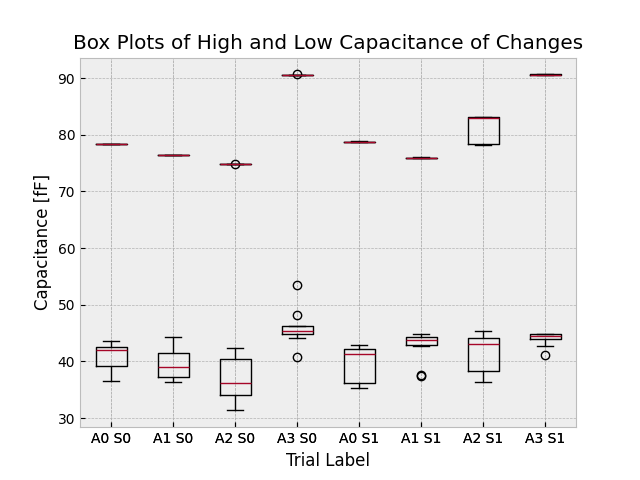

In [8]:
change_padding = 5

fig, ax = plt.subplots()
high_data = []
low_data = []
trial_labels = []

for trial in cyclic_trials:
    electrode = trial.trial_name.split("_")[2]
    trial_num = trial.trial_name.split("_")[-1][:2]
    trial_labels.append(f"{electrode} {trial_num}")

    algo = rpt.Pelt(model="rbf").fit(trial.cap_counts)
    change_points = np.array(algo.predict(pen=10))
    region_starts = np.r_[0, change_points[:-1] + change_padding]
    region_ends = change_points - change_padding

    trial_high_data = []
    trial_low_data = []

    for idx, (start, end) in enumerate(zip(region_starts, region_ends)):
        data_slice = count2ff(trial.cap_counts[start:end])
        median = np.median(data_slice)
        if idx % 2 == 0:
            trial_high_data.append(median)
        else:
            trial_low_data.append(median)
    
    high_data.append(np.hstack(trial_high_data))
    low_data.append(np.hstack(trial_low_data))
    
ax.boxplot(high_data, tick_labels=trial_labels)
ax.boxplot(low_data, tick_labels=trial_labels)
ax.set_title("Box Plots of High and Low Capacitance of Changes")
ax.set_xlabel("Trial Label")
ax.set_ylabel("Capacitance [fF]")

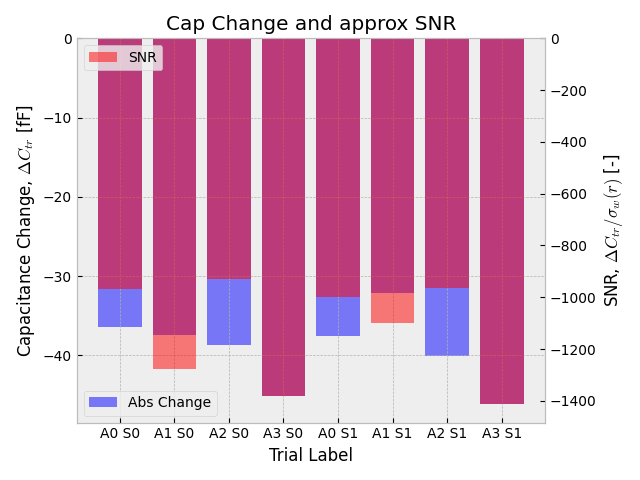

In [41]:
# Data is processed this way because it's ragged because I missed a place/pick :)
high_data = np.array([np.median(trial) for trial in high_data])
low_data = np.array([np.median(trial) for trial in low_data])
cap_change = low_data - high_data

fig, ax = plt.subplots()
ax.bar(trial_labels, cap_change, color="b", alpha=0.5, label="Abs Change")
twinx = ax.twinx()
twinx.bar(trial_labels, cap_change/np.tile(sigma_ws, 2), color="r", alpha = 0.5, label="SNR")
twinx.grid(False)

ax.set_ylabel(r"Capacitance Change, $\Delta C_{tr}$ [fF]")
twinx.set_ylabel(r"SNR, $\Delta C_{tr} / \sigma_w(r)$ [-]")
ax.legend()
twinx.legend(loc=2)

ax.set_title("Cap Change and approx SNR")
ax.set_xlabel("Trial Label")
plt.tight_layout()